#### A classification project for time-series data using Random Forest classifier

In [1]:
#import libraries
import yfinance as yf
import pandas as pd
import talib
from talib import abstract #conda install -c conda-forge ta-lib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import joblib

pd.set_option('display.max_rows', 600)

In [2]:
#import yahoo stock data
data = yf.Ticker('SPY').history(start='1990-01-29') #get the yahoo stock data start from the beginning
data.columns = ['open','high','low','close','volume','dividends','split'] #renamce columns
data.head()

,open,high,low,close,volume,dividends,split
Date,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,0
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,0
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,0
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,0
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,0


In [3]:
#data pre-processing of cyclical features
#this step helps classification on time-series data
#source: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
#note year is not cyclical features
data['year'] = data.index.to_series().dt.year.to_list()
data['month'] = data.index.to_series().dt.month.to_list()
data['day'] = data.index.to_series().dt.day.to_list()
data['weekday'] = data.index.to_series().dt.dayofweek.to_list()

data['month_sin'] = np.sin(data.month*(2.*np.pi/12))
data['month_cos'] = np.cos(data.month*(2.*np.pi/12))

data['day_sin'] = np.sin(data.day*(2.*np.pi/30))
data['day_cos'] = np.cos(data.day*(2.*np.pi/30))

data['weekday_sin'] = np.sin(data.weekday*(2.*np.pi/7))
data['weekday_cos'] = np.cos(data.weekday*(2.*np.pi/7))

data.head()

,open,high,low,close,volume,dividends,split,year,month,day,weekday,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
Date,,,,,,,,,,,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,0,1993,1,29,4,0.500000,0.866025,-0.207912,0.978148,-0.433884,-0.900969
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,0,1993,2,1,0,0.866025,0.500000,0.207912,0.978148,0.000000,1.000000
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,0,1993,2,2,1,0.866025,0.500000,0.406737,0.913545,0.781831,0.623490
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,0,1993,2,3,2,0.866025,0.500000,0.587785,0.809017,0.974928,-0.222521
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,0,1993,2,4,3,0.866025,0.500000,0.743145,0.669131,0.433884,-0.900969


##### The date information is extracted from the index column and its relative trigonometry functions are also computed for time-series classification.

In [4]:
#compute indicators for the dataset
ind_list = talib.get_functions() #get all indicators for financial analysis

temp = data
#compute each indicator for the dataset
#source: 
for ind in ind_list:
    if ind != 'MAVP': #MAVP needs periods
        output = eval('abstract.' + ind + '(data)')
    else:
        output = eval('talib.MAVP(data.close, periods=data.index.to_series(), minperiod=2, maxperiod=30, matype=0)')
    output.name = ind.lower() if type(output) == pd.core.series.Series else None #rename for 1D output
    temp = pd.merge(temp, pd.DataFrame(output), 
                    left_on = temp.index, 
                    right_on = output.index).set_index('key_0') #merge output with original data
ind_data = temp
ind_data.head()

,open,high,low,close,volume,dividends,split,year,month,day,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,0,1993,1,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.165714e+05,NaN,1003200.0
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,0,1993,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.183502,1.197071e+06,NaN,1483700.0
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,0,1993,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.146798,1.348046e+06,NaN,1685000.0
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,0,1993,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0.293601,1.806860e+06,NaN,2214400.0
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,0,1993,2,4,...,NaN,0.226824,NaN,0.051449,NaN,NaN,0.366995,2.178910e+06,NaN,2745900.0


##### All the indices from talib are computed. This increases the degree of freedom when performing feature selection as more combinations of features are provided. However, more or less features does not necessarily mean better or worse prediction.

In [5]:
#check null
ind_data.isnull().sum().describe()

count     192.000000
mean       85.078125
std       731.758893
min         0.000000
25%         0.000000
50%         0.000000
75%        14.000000
max      7197.000000
dtype: float64

##### The statistics tells that may indices contains null/na/nan values

In [6]:
#remove column that has a lot of null (3% of the sample number)
#otherwise replace null by mean
clean_data = ind_data
for col in clean_data.columns:
    if clean_data[col].isnull().sum() > 0.03*len(clean_data):
        clean_data.drop(col, axis=1, inplace=True)
clean_data = clean_data.fillna(clean_data.mean())
clean_data.head()

,open,high,low,close,volume,dividends,split,year,month,day,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,0,1993,1,29,...,0.058208,0.941437,124.545171,2.012480,1.646414,1.39907,1.649420,7.165714e+05,1.879060e+07,1003200.0
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,0,1993,2,1,...,0.058208,0.941437,124.545171,2.012480,1.646414,1.39907,0.183502,1.197071e+06,1.879060e+07,1483700.0
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,0,1993,2,2,...,0.058208,0.941437,124.545171,2.012480,1.646414,1.39907,0.146798,1.348046e+06,1.879060e+07,1685000.0
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,0,1993,2,3,...,0.058208,0.941437,124.545171,2.012480,1.646414,1.39907,0.293601,1.806860e+06,1.879060e+07,2214400.0
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,0,1993,2,4,...,0.058208,0.226824,124.545171,0.051449,1.646414,1.39907,0.366995,2.178910e+06,1.879060e+07,2745900.0


##### As the nulls occurs within the indices not the original data, replacing some of them rather than removing all of them maintains the variability of the dataset. Other than mean, median or mod can also be used to replace the null.

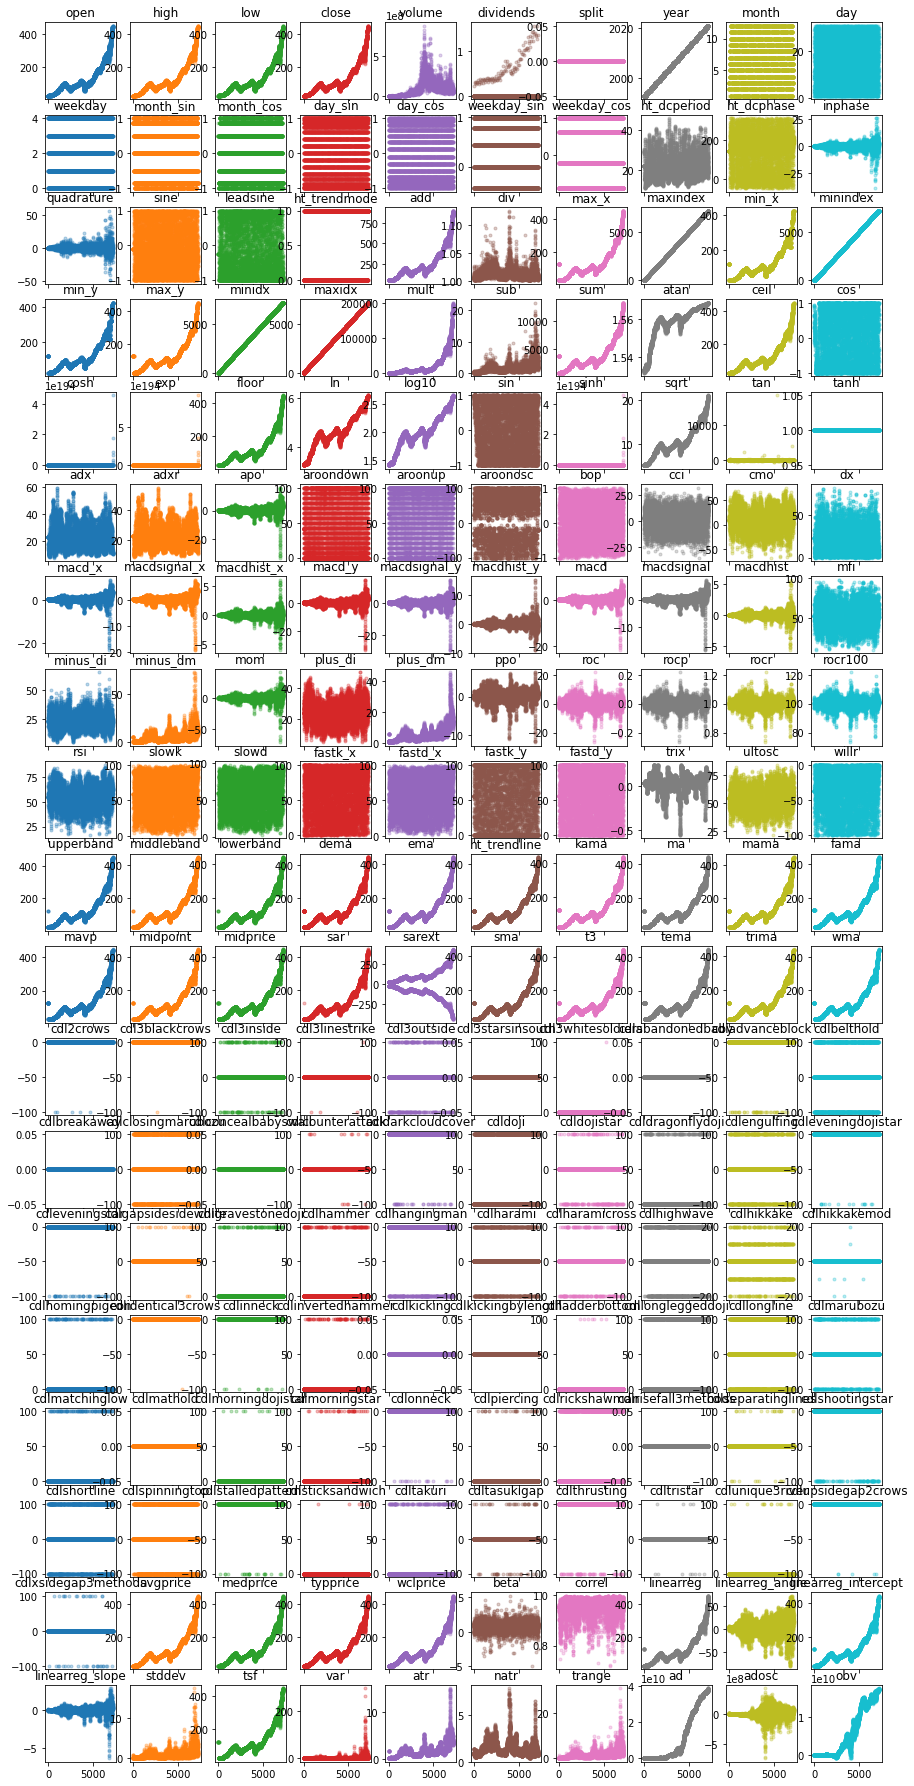

In [7]:
#visua;ize the dataset
clean_data.plot(style='.', subplots=True, legend=False, use_index=False, alpha=0.3,
                title=list(clean_data.columns), layout=(19,10), figsize=(15,32)); #colormap="winter"

##### The visualizations show that there are certain 'outliers' lie within some features such as 'max_x' and 'max_y'. However, outliers do not necessarily mean they are invalid data points. Moreover, there are some features exhibiting triviality as they contain only same values. Performing feature selection can remove the unimportant features. The appropriate algorithm will be using tree algorithms such as Random Forest which are not sensitive to outliers.

In [8]:
#scale the data between -1 and 1
#useful for svm or knn
#little effect on random forest
transformed_data = clean_data
scaler = MinMaxScaler(feature_range=(-1,1))
transformed_data.iloc[:,:] = scaler.fit_transform(transformed_data)
transformed_data.head()

,open,high,low,close,volume,dividends,split,year,month,day,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,-0.998439,-0.998788,-0.997395,-0.998527,-0.997708,-1.0,-1.0,-1.0,-1.000000,0.866667,...,0.387411,-0.892089,-0.529406,-0.986504,-0.797643,-0.727353,-0.896439,-1.000000,0.287452,-0.902796
1993-02-01,-0.998439,-0.998009,-0.996787,-0.997660,-0.998909,-1.0,-1.0,-1.0,-0.818182,-1.000000,...,0.387411,-0.892089,-0.529406,-0.986504,-0.797643,-0.727353,-0.990612,-0.999975,0.287452,-0.902744
1993-02-02,-0.997745,-0.997662,-0.996353,-0.997400,-0.999550,-1.0,-1.0,-1.0,-0.818182,-0.933333,...,0.387411,-0.892089,-0.529406,-0.986504,-0.797643,-0.727353,-0.992970,-0.999967,0.287452,-0.902722
1993-02-03,-0.997224,-0.996364,-0.995658,-0.996100,-0.998796,-1.0,-1.0,-1.0,-0.818182,-0.866667,...,0.387411,-0.892089,-0.529406,-0.986504,-0.797643,-0.727353,-0.983539,-0.999944,0.287452,-0.902665
1993-02-04,-0.995663,-0.995671,-0.995398,-0.995580,-0.998792,-1.0,-1.0,-1.0,-0.818182,-0.800000,...,0.387411,-0.974900,-0.529406,-0.999656,-0.797643,-0.727353,-0.978824,-0.999924,0.287452,-0.902608


##### All the features are standardize that they range between -1 and 1. This step is trivial for Random Forest or Decision Tree classifier, while it helps improve the performance when using SVM or KNN classifier which uses distance vector. 

In [9]:
#create new column to indicate rise/drop after 5 days
#observed that rise is about 1000 more than drop
transformed_data['target'] = np.where(transformed_data.close.shift(-5) > transformed_data.close, 1, -1)
transformed_data['target'].value_counts()

 1    4222
-1    2975
Name: target, dtype: int64

##### It can seen that the difference in number is more than 1000. This means that there will be some bias in the dataset, which will affect the classification.

In [10]:
#pearson correlation
cor = transformed_data.corr()
abs(cor['target']).sort_values(ascending=False)

target                 1.000000
fastd_y                0.058802
ad                     0.056407
fastk_x                0.056198
fastd_x                0.052629
slowk                  0.052367
fastk_y                0.051195
obv                    0.050525
month_cos              0.045411
mult                   0.044243
t3                     0.040136
min_x                  0.039847
min_y                  0.039847
middleband             0.039570
lowerband              0.039563
upperband              0.039561
sum                    0.039521
sma                    0.039521
ma                     0.039521
ema                    0.039486
trima                  0.039370
wma                    0.039364
kama                   0.039215
cci                    0.039197
open                   0.039100
mavp                   0.039081
low                    0.039041
sar                    0.039036
medprice               0.038998
add                    0.038998
fama                   0.038984
max_y   

##### The pearson correlation is used to investigate the direct correlation between each independent variable and traget variable. The features that give NaN in pearson coefficient will be removed.

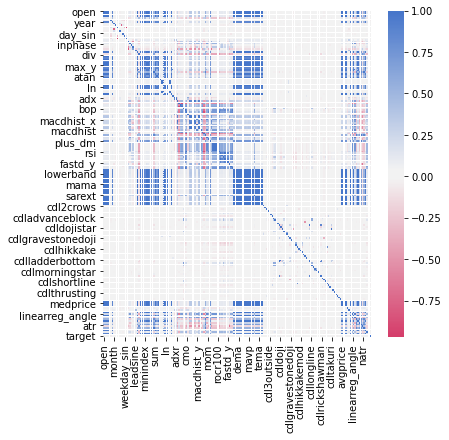

In [11]:
#remove uncorrelated features
transformed_data = transformed_data[cor['target'].dropna().index.to_list()]
cor = transformed_data.corr()
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(0, 255, sep=9, n=256)
sns.heatmap(cor, cmap=cmap, linewidths=.001);

##### As shown that all features exhibit weak correaltion with the target varaible.

In [12]:
abs(cor.target).describe()

count    181.000000
mean       0.026202
std        0.074414
min        0.000194
25%        0.006876
50%        0.018596
75%        0.038089
max        1.000000
Name: target, dtype: float64

##### Reducing dimentionality may improve the accuracy. Hence, here will remove some features that has very little correlation with the target.

In [13]:
#remove the least correlated features
selected_data = transformed_data[cor.target[cor.target > 0.019].index.to_list()]
selected_data.head()

,open,high,low,close,year,month,month_cos,day_sin,day_cos,weekday_sin,...,medprice,typprice,wclprice,linearreg,linearreg_intercept,stddev,tsf,ad,obv,target
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,-0.998439,-0.998788,-0.997395,-0.998527,-1.0,-1.000000,0.866025,-0.209057,0.978148,-1.000000,...,-0.998656,-0.998613,-0.998591,-0.529641,-0.528625,-0.892089,-0.529406,-1.000000,-0.902796,1
1993-02-01,-0.998439,-0.998009,-0.996787,-0.997660,-1.0,-0.818182,0.500000,0.209057,0.978148,-0.384043,...,-0.997962,-0.997861,-0.997811,-0.529641,-0.528625,-0.892089,-0.529406,-0.999975,-0.902744,1
1993-02-02,-0.997745,-0.997662,-0.996353,-0.997400,-1.0,-0.818182,0.500000,0.408977,0.913545,0.725873,...,-0.997572,-0.997514,-0.997486,-0.529641,-0.528625,-0.892089,-0.529406,-0.999967,-0.902722,1
1993-02-03,-0.997224,-0.996364,-0.995658,-0.996100,-1.0,-0.818182,0.500000,0.591023,0.809017,1.000000,...,-0.996574,-0.996416,-0.996337,-0.529641,-0.528625,-0.892089,-0.529406,-0.999944,-0.902665,-1
1993-02-04,-0.995663,-0.995671,-0.995398,-0.995580,-1.0,-0.818182,0.500000,0.747238,0.669131,0.231914,...,-0.996097,-0.995925,-0.995838,-0.529641,-0.528625,-0.974900,-0.529406,-0.999924,-0.902608,-1


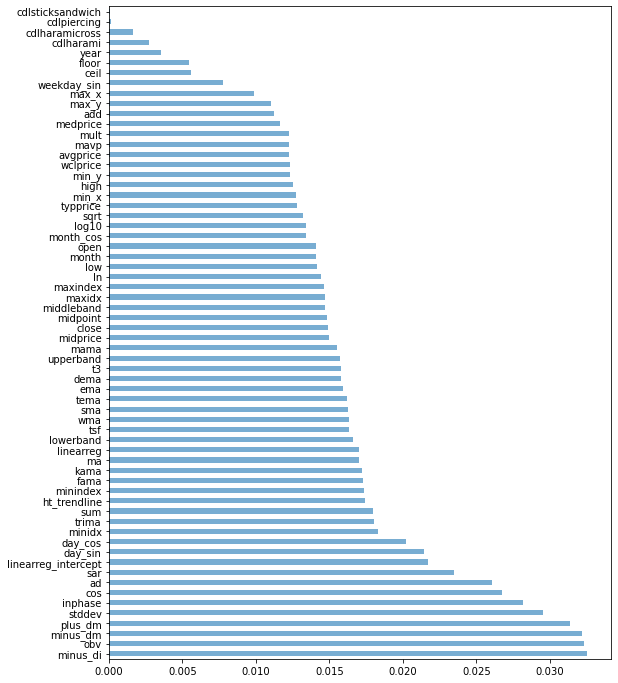

In [14]:
#feature importance using randomforest
x = selected_data.drop('target', axis=1)
y = selected_data.target
#split data for train and test
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=3, shuffle=True)

#fit the model
model = rfc()
model.fit(train_x, train_y)

feature_importance = pd.Series(model.feature_importances_, index=selected_data.drop('target', axis=1).columns)
feature_importance.nlargest(len(selected_data)).plot(kind='barh', alpha=.6, figsize=(9,12));

##### From the barchart, most of the features exhibit certain degree of importance. It would be better to keep most of them.

In [15]:
feature_importance.describe()

count    64.000000
mean      0.015625
std       0.007250
min       0.000050
25%       0.012344
50%       0.014932
75%       0.017379
max       0.032528
dtype: float64

In [35]:
#recursive feature elimination with cross-validation using Random Forest to find the optimal number of features and the features
#feature selection can be done by setting a threshold if this step takes a lot of time
model = rfc()
rfecv = RFECV(estimator=model, step=1, cv=6, scoring='accuracy') #use 6-fold cross validation
rfecv = rfecv.fit(train_x, train_y)
optimal_features = train_x.columns[rfecv.support_]
print(len(optimal_features))
print(optimal_features)

41
Index(['low', 'close', 'month', 'day_sin', 'day_cos', 'inphase', 'maxindex',
       'minindex', 'minidx', 'sum', 'cos', 'ln', 'sqrt', 'minus_di',
       'minus_dm', 'plus_dm', 'upperband', 'middleband', 'lowerband', 'dema',
       'ema', 'ht_trendline', 'kama', 'ma', 'mama', 'fama', 'midprice', 'sar',
       'sma', 't3', 'tema', 'trima', 'wma', 'avgprice', 'wclprice',
       'linearreg', 'linearreg_intercept', 'stddev', 'tsf', 'ad', 'obv'],
      dtype='object')


##### As observed that, the optimal features selected by recursive feature elimination with cross validation are those that exhibits high importance on the feature importance barchart.

In [23]:
#remove features with very little importance
# selected_data = selected_data[feature_importance[feature_importance > 0.003].index.to_list()]
#choose features from recursive cross validation
selected_data = selected_data[optimal_features]
selected_data.head()

,low,close,month,day_sin,day_cos,inphase,maxindex,minindex,minidx,sum,...,trima,wma,avgprice,wclprice,linearreg,linearreg_intercept,stddev,tsf,ad,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,-0.997395,-0.998527,-1.000000,-0.209057,0.978148,0.20678,-1.0,-1.0,-1.0,-0.5286,...,-0.528829,-0.529887,-0.998677,-0.998591,-0.529641,-0.528625,-0.892089,-0.529406,-1.000000,-0.902796
1993-02-01,-0.996787,-0.997660,-0.818182,0.209057,0.978148,0.20678,-1.0,-1.0,-1.0,-0.5286,...,-0.528829,-0.529887,-0.998113,-0.997811,-0.529641,-0.528625,-0.892089,-0.529406,-0.999975,-0.902744
1993-02-02,-0.996353,-0.997400,-0.818182,0.408977,0.913545,0.20678,-1.0,-1.0,-1.0,-0.5286,...,-0.528829,-0.529887,-0.997680,-0.997486,-0.529641,-0.528625,-0.892089,-0.529406,-0.999967,-0.902722
1993-02-03,-0.995658,-0.996100,-0.818182,0.591023,0.809017,0.20678,-1.0,-1.0,-1.0,-0.5286,...,-0.528829,-0.529887,-0.996725,-0.996337,-0.529641,-0.528625,-0.892089,-0.529406,-0.999944,-0.902665
1993-02-04,-0.995398,-0.995580,-0.818182,0.747238,0.669131,0.20678,-1.0,-1.0,-1.0,-0.5286,...,-0.528829,-0.529887,-0.995966,-0.995838,-0.529641,-0.528625,-0.974900,-0.529406,-0.999924,-0.902608


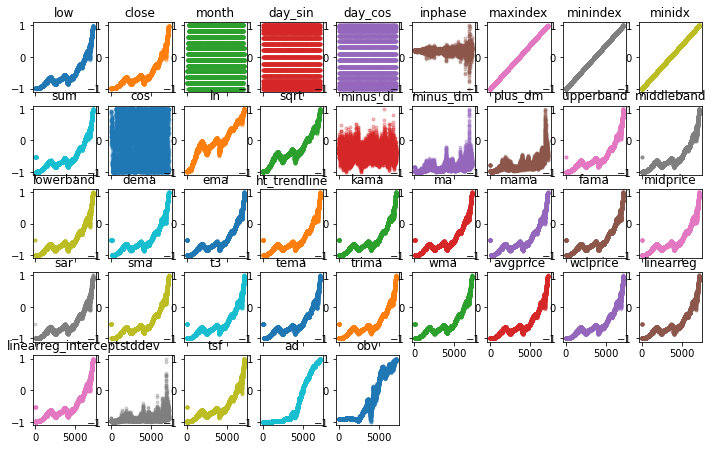

In [24]:
#visualize the final data before machine learning
selected_data.plot(style='.', subplots=True, legend=False, use_index=False, alpha=0.3,
                title=list(selected_data.columns), layout=(5,9), figsize=(12,12)); #colormap="winter"

##### As mentioned, feature selection has successfully remove all the trivial features and some unimportant features. There are still a small numer of 'outliers' being trained, however, using Random Forest.

In [25]:
#prepare train and test sets
final_data = selected_data
x = final_data
y = np.where(transformed_data.close.shift(-5) > transformed_data.close, 1, -1)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=3, shuffle=True)

##### The train and test data are splitted randomly from the original dataset. The time-series data can be randomly splitted since the date information and its trigonometry functions were computed and made to be the independent variables.

234


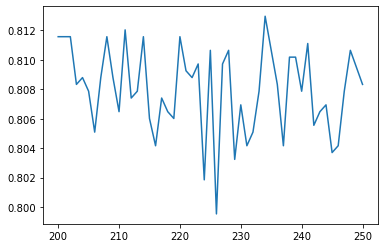

In [36]:
#tune hyperparameters to get highest accuracy
#
accuracy = []
parameter = np.linspace(200, 250, num=50, dtype='int')
for n in parameter:
    model = rfc(n_estimators=n, max_depth=98)
    model.fit(train_x, train_y)
    prediction = model.predict(test_x)
    accuracy.append(model.score(test_x, test_y))
pd.Series(accuracy,parameter).plot()
print(pd.Series(accuracy,parameter).idxmax())

              precision    recall  f1-score   support

          -1       0.80      0.73      0.76       897
           1       0.82      0.87      0.84      1263

    accuracy                           0.81      2160
   macro avg       0.81      0.80      0.80      2160
weighted avg       0.81      0.81      0.81      2160



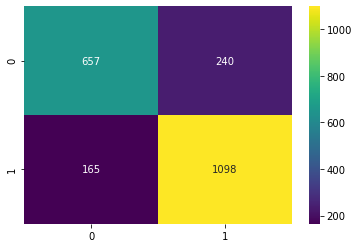

In [37]:
#perform prediction and show report
#default parameter also yield good accuracy
model = rfc(n_estimators=234, max_depth=98)
model.fit(train_x, train_y)
prediction = model.predict(test_x)
sns.heatmap(confusion_matrix(test_y, prediction), cmap='viridis', annot=True, fmt='d');
print(classification_report(test_y, prediction))

##### The 81% test accuracy looks promising. The model also exhibits high precision. However, the recall of '-1' is 72% which is 14% lower than the recall of '1'. This means that although the algorithm exhibits high accuracy and precision in predicting rise and decline of the market, it lacks high sensitivity of predicting decline. It is expected as there was some bias within the dataset as mentioned. To minimize the bias, resampling can be performed. However, how well the resampling on such dataset will need to be investigated. If a safer stock investment approach is preferred, an algorithm with higher sensitivity to decline is highly required.

In [38]:
#save the model
#load the model and predict the whole dataset
#the new accuracy should be 0.7+0.3*previous accuracy
joblib.dump(model, "stock_movement_rfc.pkl") 
loaded_model = joblib.load("stock_movement_rfc.pkl")
new_prediction = loaded_model.predict(final_data)
print(classification_report(y, new_prediction))

              precision    recall  f1-score   support

          -1       0.94      0.92      0.93      2975
           1       0.94      0.96      0.95      4222

    accuracy                           0.94      7197
   macro avg       0.94      0.94      0.94      7197
weighted avg       0.94      0.94      0.94      7197

